#### 讀取檔案

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Image Shap: (165, 220, 3)


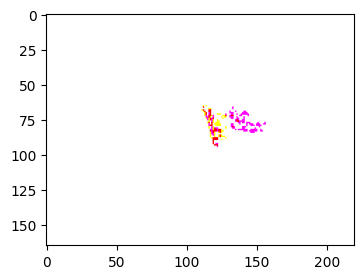

In [197]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np 

img = Image.open("apple.jpg")
HSI = np.array(img, dtype='float64')

plt.figure(figsize = (5,3))
plt.imshow(HSI)

print("Image Shap:", HSI.shape)

#### Method 

In [ ]:
# 設計一個 w 濾波器 條件必須 目標點與濾波器 w 相乘必須為 1
def CEM(HSI, target):
    H, W, N = HSI.shape
    HSI_2D = HSI.reshape(-1, N)

    R = np.dot(HSI_2D.T, HSI_2D) / H * W # shape(N, N)

    try:
        inv_R = np.linalg.inv(R) # shape(N, N)
    except:
        inv_R = np.linalg.pinv(R) # shape(N, N)

    w = inv_R @ target / ((target.T @ inv_R) @ target) # shape(N, 1) =  shape(N, 1) / (shape(1, N) @ shape(N, 1))
   
    return  HSI_2D @ w # shape(H, W, 1)

# r, d 之間光譜特徵的資訊差異度
def SID(HSI, target):
    """
    HSI: shape (H, W, B)
    target: shape (B,)
    return: SID map, shape (H, W)
    """

    p = HSI / np.sum(HSI, axis=2, keepdims=True)     # shape: (H, W, B)
    q = target / np.sum(target)                   # shape: (B,)

    # Compute SID
    sid_1 = np.sum(p * np.log(p / q.reshape(1, 1, -1)), axis=2)  # shape: (H, W)
    sid_2 = np.sum(q.reshape(1, 1, -1) * np.log(q.reshape(1, 1, -1) / p), axis=2)

    sid_total = sid_1 + sid_2
    return sid_total

# 計算點雨點光譜之間的角度相似性
def SAM(HSI, target):
    """
    HSI: shape (H, W, B)
    target: shape (B,) or (B, 1)
    return: SAM map, shape (H, W)
    """

    H, W, B = HSI.shape
    HSI_2D = HSI.reshape(-1, B)              # shape: (H*W, B)
    target = target.reshape(-1)              # 保證 target 為 (B,)

    dot_product = np.sum(HSI_2D * target, axis=1)
    HSI_norm = np.linalg.norm(HSI_2D, axis=1)
    target_norm = np.linalg.norm(target)

    denominator = HSI_norm * target_norm 
    cos_theta = dot_product / denominator
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # 保證值不超出 arccos 定義域

    angles = np.arccos(cos_theta)              # 弧度

    return angles.reshape(H, W)

C:\Users\Shuwei\AppData\Local\Temp\ipykernel_25092\3659574398.py:28: RuntimeWarning: divide by zero encountered in log
  sid_1 = np.sum(p * np.log(p / q.reshape(1, 1, -1)), axis=2)  # shape: (H, W)
C:\Users\Shuwei\AppData\Local\Temp\ipykernel_25092\3659574398.py:28: RuntimeWarning: invalid value encountered in multiply
  sid_1 = np.sum(p * np.log(p / q.reshape(1, 1, -1)), axis=2)  # shape: (H, W)
C:\Users\Shuwei\AppData\Local\Temp\ipykernel_25092\3659574398.py:29: RuntimeWarning: divide by zero encountered in divide
  sid_2 = np.sum(q.reshape(1, 1, -1) * np.log(q.reshape(1, 1, -1) / p), axis=2)


Text(0.5, 1.0, 'SAM')

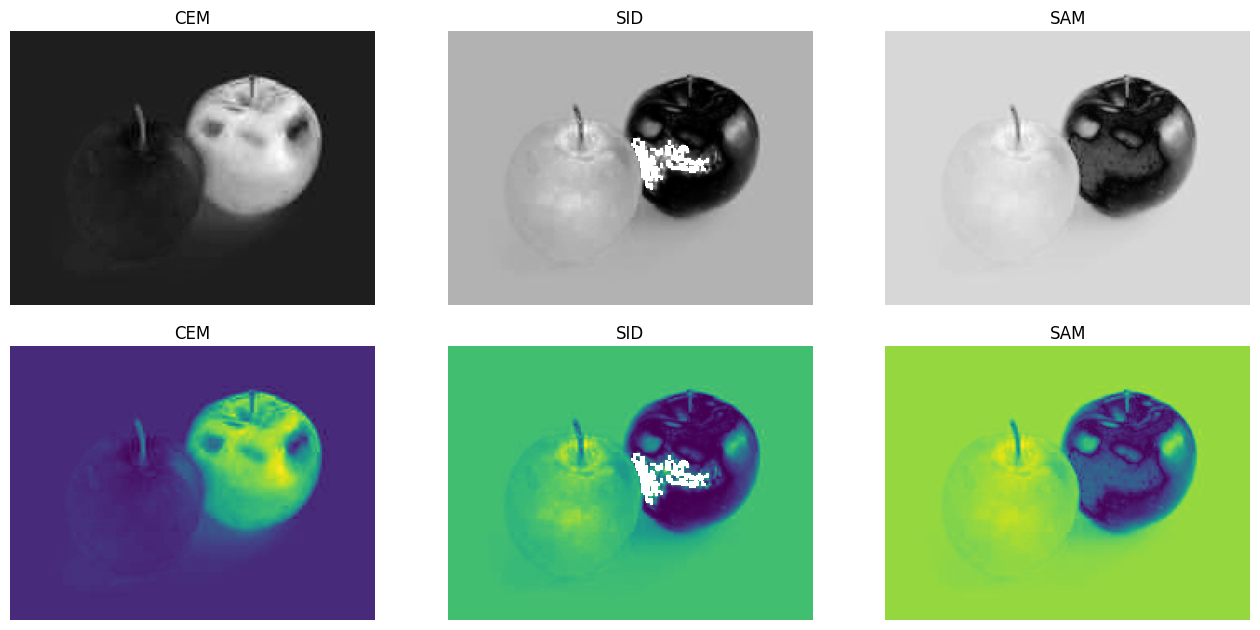

In [196]:
H, W, B = HSI.shape

target = HSI[60, 150].reshape(-1, 1)

resCEM = CEM(HSI, target)
resSID = SID(HSI, target)
resSAM = SAM(HSI, target)

img1 = resCEM.reshape(H, W)
img2 = resSID.reshape(H, W)
img3 = resSAM.reshape(H, W)


plt.figure(figsize=(16, 15))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("CEM")
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("SID")
plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis('off')
plt.title("SAM")

plt.subplot(2, 3, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title("CEM")
plt.subplot(2, 3, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title("SID")
plt.subplot(2, 3, 3)
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.title("SAM")


